### Installing Libraries

In [ ]:
!pip install -U --pre tensorflow=="2.*"
!pip install tf_slim
!pip install pycocotools

In [ ]:
!pip install object_detection
!pip install utils

### Importing Libraries

In [ ]:
import os
import pathlib

if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
%%bash
cd models/research
# Compile protos.
protoc object_detection/protos/*.proto --python_out=.
# Install TensorFlow Object Detection API.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for object_detection: filename=object_detection-0.1-py3-none-any.whl size=1697358 sha256=316bdc78daecfb7151e472093294293ea9e5bcb00508a4621d9d0781a05cf90b
  Stored in directory: /tmp/pip-ephem-wheel-cache-gnvllh6w/wheels/53/dd/70/2de274d6c443c69d367bd6a5606f95e5a6df61aacf1435ec0d
Successfully built object_detection
  Attempting uninstall: object_detection
    Found existing installation: object_detection 0.1
    Uninstalling object_detection-0.1:
      Successfully uninstalled object_detection-0.1


In [ ]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

In [ ]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

### Custom Functions

In [ ]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name,
    origin=base_url + model_file,
    untar=True)
  print(model_dir)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']

  return model

In [ ]:
load_model()

### Loading Label maps

In [ ]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [ ]:
category_index

{1: {'id': 1, 'name': 'person'},
 2: {'id': 2, 'name': 'bicycle'},
 3: {'id': 3, 'name': 'car'},
 4: {'id': 4, 'name': 'motorcycle'},
 5: {'id': 5, 'name': 'airplane'},
 6: {'id': 6, 'name': 'bus'},
 7: {'id': 7, 'name': 'train'},
 8: {'id': 8, 'name': 'truck'},
 9: {'id': 9, 'name': 'boat'},
 10: {'id': 10, 'name': 'traffic light'},
 11: {'id': 11, 'name': 'fire hydrant'},
 13: {'id': 13, 'name': 'stop sign'},
 14: {'id': 14, 'name': 'parking meter'},
 15: {'id': 15, 'name': 'bench'},
 16: {'id': 16, 'name': 'bird'},
 17: {'id': 17, 'name': 'cat'},
 18: {'id': 18, 'name': 'dog'},
 19: {'id': 19, 'name': 'horse'},
 20: {'id': 20, 'name': 'sheep'},
 21: {'id': 21, 'name': 'cow'},
 22: {'id': 22, 'name': 'elephant'},
 23: {'id': 23, 'name': 'bear'},
 24: {'id': 24, 'name': 'zebra'},
 25: {'id': 25, 'name': 'giraffe'},
 27: {'id': 27, 'name': 'backpack'},
 28: {'id': 28, 'name': 'umbrella'},
 31: {'id': 31, 'name': 'handbag'},
 32: {'id': 32, 'name': 'tie'},
 33: {'id': 33, 'name': 'suitc

In [ ]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('models/research/object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[PosixPath('models/research/object_detection/test_images/image1.jpg'),
 PosixPath('models/research/object_detection/test_images/image2.jpg'),
 PosixPath('models/research/object_detection/test_images/image3.jpg')]

### Object Detection

In [ ]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy()
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)

  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()

  return output_dict

In [ ]:
def show_inference(model, image):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  #image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image))

array([[[253, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 254, 255],
        [249, 255, 255],
        [213, 224, 231],
        ...,
        [188, 188, 183],
        [189, 189, 184],
        [236, 237, 235]],

       [[216, 213, 216],
        [146, 157, 165],
        [ 71,  82,  89],
        ...,
        [ 46,  45,  41],
        [ 42,  41,  36],
        [193, 194, 192]],

       ...,

       [[255, 255, 253],
        [255, 255, 255],
        [160, 156, 154],
        ...,
        [206, 208, 203],
        [128, 130, 125],
        [193, 194, 192]],

       [[255, 255, 253],
        [255, 255, 255],
        [160, 156, 154],
        ...,
        [175, 175, 173],
        [119, 120, 117],
        [192, 192, 192]],

       [[255, 255, 255],
        [255, 255, 255],
        [160, 156, 154],
        ...,
        [134, 135, 132],
        [119, 120, 117],
        [214, 214, 214]]], dtype=uint8)
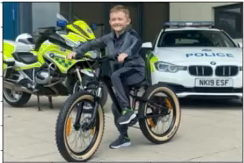

In [ ]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread('Object Detection Image.png')
img


[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]


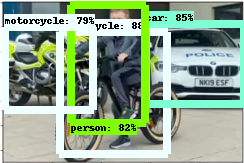

None


In [ ]:
model_name = 'ssd_mobilenet_v1_coco_2017_11_17'
detection_model = load_model(model_name)

print(detection_model.inputs)
detection_model.output_dtypes

print(show_inference(detection_model,img))

In [ ]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image_np))

In [ ]:
model_name = 'ssd_mobilenet_v1_coco_2017_11_17'
detection_model = load_model(model_path)

for image_path in TEST_IMAGE_PATHS:
  show_inference(detection_model, image_path)